In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter

In [2]:
DATA_DIR = '/home/system/datasets/gallbladder1/crop'
x_train_dir = os.path.join(DATA_DIR, 'train/img')
y_train_dir = os.path.join(DATA_DIR, 'train/mask')

x_valid_dir = os.path.join(DATA_DIR, 'val/img')
y_valid_dir = os.path.join(DATA_DIR, 'val/mask')

x_test_dir = os.path.join(DATA_DIR, 'vis/img')
y_test_dir = os.path.join(DATA_DIR, 'vis/mask')

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['0', 'gallbladder']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            transform=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id).split('.')[0] + '_gt.png' for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.transform=transform
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], -1)                # png16   -1
#         print(self.class_values)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        mask[mask != 0] = 1
#         print(mask.max())
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.transform:
            image = self.transform(image)
        return image, mask
        
    def __len__(self):
        return len(self.ids)

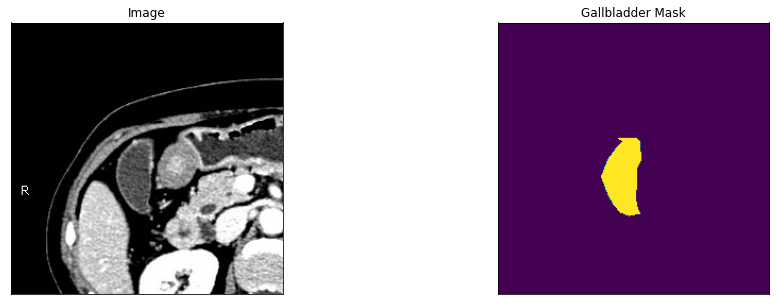

In [5]:
# Lets look at data we have

dataset = Dataset(x_test_dir, y_test_dir, classes=['gallbladder'])

image, mask = dataset[3] # get some sample

visualize(
    image=image, 
    gallbladder_mask=mask.squeeze(),
)

In [6]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [7]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.ColorJitter(brightness=0, contrast=1, saturation=0, hue=0),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.18, .18, .18)),
    
])

In [8]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['gallbladder']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
write = SummaryWriter('logs')
# create segmentation model with pretrained encoder
model = smp.Unet(
#     encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [9]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
#     augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
#     transform=train_transforms,
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
#     augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
#     transform=train_transforms,
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.64
1.0


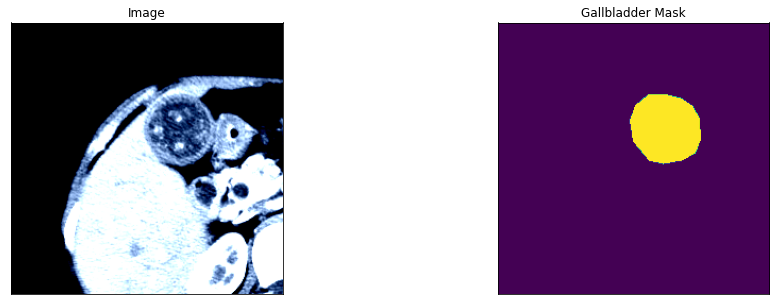

In [10]:
i = 0
for img, msk in train_loader:
    if i == 0:
        img = np.array(img)
        msk = np.array(msk)
        print(img.max())
        print(msk.max())
        visualize(
            image=img[0].transpose(1, 2, 0), 
            gallbladder_mask=msk[0].transpose(1, 2, 0).squeeze(),
        )
    else:
        break
    i+=1

In [11]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
EPOCHS = 50
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.Precision(),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.01),
])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-5)

In [12]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [14]:
# train model for 40 epochs

max_score = 0

for i in range(0, EPOCHS):
    lr = scheduler.get_last_lr()
    print('\nEpoch: {},lr:{}'.format(i, lr))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './models/unet_best_model_8_1.pth')
        print('Model saved!')
    scheduler.step()   
    write.add_scalars('Train_val_loss', {'train_loss' + str(EPOCHS): train_logs['dice_loss']}, i + 1)
    write.add_scalars('Train_val_loss', {'val_loss' + str(EPOCHS): valid_logs['dice_loss']}, i + 1)
    write.add_scalars('IoU_score', {'train_IoU_score' + str(EPOCHS): train_logs['iou_score']}, i + 1)
    write.add_scalars('IoU_score', {'val_IoU_score' + str(EPOCHS): valid_logs['iou_score']}, i + 1)
    write.add_scalars('f_score', {'train_fscore' + str(EPOCHS): train_logs['fscore']}, i + 1)
    write.add_scalars('f_score', {'val_fscore' + str(EPOCHS): valid_logs['fscore']}, i + 1)
    write.add_scalars('accuracy', {'train_accuracy' + str(EPOCHS): train_logs['accuracy']}, i + 1)
    write.add_scalars('accuracy', {'val_accuracy' + str(EPOCHS): valid_logs['accuracy']}, i + 1)
    write.add_scalars('recall', {'train_recall' + str(EPOCHS): train_logs['recall']}, i + 1)
    write.add_scalars('recall', {'val_recall' + str(EPOCHS): valid_logs['recall']}, i + 1)
    write.add_scalars('precision', {'train_precision' + str(EPOCHS): train_logs['precision']}, i + 1)
    write.add_scalars('precision', {'val_precision' + str(EPOCHS): valid_logs['precision']}, i + 1)
    if i < 2:
#         optimizer.param_groups[0]['lr'] = 1e-5
#         print('Decrease decoder learning rate to 1e-5!')
        print('valid_logs',valid_logs)
        print('train_logs', train_logs)


Epoch: 0,lr:[0.01]
valid: 100%|██████████| 155/155 [00:07<00:00, 19.51it/s, dice_loss - 0.407, iou_score - 0.4327, fscore - 0.593, accuracy - 0.0, recall - 0.5301, precision - 0.7137]  
Model saved!
valid_logs {'dice_loss': 0.4070480177479406, 'iou_score': 0.43270603562555005, 'fscore': 0.5929679078440518, 'accuracy': 0.0, 'recall': 0.5300954883137053, 'precision': 0.7136812558097224}
train_logs {'dice_loss': 0.2786665194392823, 'iou_score': 0.5668582173517953, 'fscore': 0.7218674625139782, 'accuracy': 0.0, 'recall': 0.7315428371256497, 'precision': 0.7203215147547155}

Epoch: 1,lr:[0.009990143508499217]
valid: 100%|██████████| 155/155 [00:05<00:00, 26.26it/s, dice_loss - 0.3549, iou_score - 0.4844, fscore - 0.6452, accuracy - 0.0, recall - 0.5764, precision - 0.7612]
Model saved!
valid_logs {'dice_loss': 0.3549403025257973, 'iou_score': 0.4843961762805138, 'fscore': 0.645192269548293, 'accuracy': 0.0, 'recall': 0.576412766402768, 'precision': 0.7612306919790085}
train_logs {'dice_los

valid: 100%|██████████| 155/155 [00:05<00:00, 26.59it/s, dice_loss - 0.2005, iou_score - 0.6734, fscore - 0.7995, accuracy - 0.0, recall - 0.7368, precision - 0.8897]
Model saved!

Epoch: 20,lr:[0.00654853988690286]
valid: 100%|██████████| 155/155 [00:05<00:00, 25.95it/s, dice_loss - 0.234, iou_score - 0.6293, fscore - 0.766, accuracy - 0.0, recall - 0.6694, precision - 0.916]   

Epoch: 21,lr:[0.006247205986388447]
valid: 100%|██████████| 155/155 [00:06<00:00, 25.68it/s, dice_loss - 0.1997, iou_score - 0.6739, fscore - 0.8003, accuracy - 0.0, recall - 0.7426, precision - 0.8818]
Model saved!

Epoch: 22,lr:[0.005940969666355694]
valid: 100%|██████████| 155/155 [00:05<00:00, 26.86it/s, dice_loss - 0.2149, iou_score - 0.6528, fscore - 0.7851, accuracy - 0.0, recall - 0.7102, precision - 0.894] 

Epoch: 23,lr:[0.0056310395016536995]
valid: 100%|██████████| 155/155 [00:05<00:00, 26.89it/s, dice_loss - 0.2214, iou_score - 0.6454, fscore - 0.7786, accuracy - 0.0, recall - 0.6941, precision -

valid: 100%|██████████| 155/155 [00:05<00:00, 27.31it/s, dice_loss - 0.2125, iou_score - 0.6568, fscore - 0.7875, accuracy - 0.0, recall - 0.7119, precision - 0.8989]

Epoch: 42,lr:[0.0006278481331809012]
valid: 100%|██████████| 155/155 [00:06<00:00, 24.87it/s, dice_loss - 0.2145, iou_score - 0.6541, fscore - 0.7855, accuracy - 0.0, recall - 0.7076, precision - 0.9005]

Epoch: 43,lr:[0.0004853888729322332]
valid: 100%|██████████| 155/155 [00:05<00:00, 25.86it/s, dice_loss - 0.2127, iou_score - 0.6564, fscore - 0.7873, accuracy - 0.0, recall - 0.7109, precision - 0.899] 

Epoch: 44,lr:[0.0003607664529881844]
valid: 100%|██████████| 155/155 [00:05<00:00, 26.08it/s, dice_loss - 0.2183, iou_score - 0.6491, fscore - 0.7817, accuracy - 0.0, recall - 0.7015, precision - 0.9005]

Epoch: 45,lr:[0.00025447270110570805]
valid: 100%|██████████| 155/155 [00:05<00:00, 25.93it/s, dice_loss - 0.2162, iou_score - 0.6518, fscore - 0.7838, accuracy - 0.0, recall - 0.7044, precision - 0.9012]

Epoch: 46,l

Epoch: 0,lr:[0.1]
train: 100%|██████████| 258/258 [03:08<00:00,  1.37it/s, dice_loss - 0.4186, iou_score - 0.4265]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.73it/s, dice_loss - 0.4803, iou_score - 0.3578]
Model saved!
valid_logs {'dice_loss': 0.480295148972542, 'iou_score': 0.3578365334580024}
train_logs {'dice_loss': 0.4185742093611131, 'iou_score': 0.42650585575029276}

Epoch: 1,lr:[0.09990134628777145]
train: 100%|██████████| 258/258 [03:11<00:00,  1.35it/s, dice_loss - 0.3061, iou_score - 0.5338]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.69it/s, dice_loss - 0.5426, iou_score - 0.3014]
valid_logs {'dice_loss': 0.542648950699837, 'iou_score': 0.3014336555234849}
train_logs {'dice_loss': 0.3061245250147444, 'iou_score': 0.5338359156320264}

Epoch: 2,lr:[0.09960577449221733]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.2714, iou_score - 0.5754]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.89it/s, dice_loss - 0.3752, iou_score - 0.4625]
Model saved!

Epoch: 3,lr:[0.0991144511001808]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.2329, iou_score - 0.6247]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.74it/s, dice_loss - 0.3762, iou_score - 0.4626]
Model saved!

Epoch: 4,lr:[0.0984293151406259]
train: 100%|██████████| 258/258 [03:10<00:00,  1.36it/s, dice_loss - 0.1993, iou_score - 0.6694]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.69it/s, dice_loss - 0.3085, iou_score - 0.5355]
Model saved!

Epoch: 5,lr:[0.0975530705321762]
train: 100%|██████████| 258/258 [03:11<00:00,  1.35it/s, dice_loss - 0.1704, iou_score - 0.7102]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.70it/s, dice_loss - 0.4267, iou_score - 0.4122]

Epoch: 6,lr:[0.09648917541198312]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.159, iou_score - 0.7269] 
valid: 100%|██████████| 155/155 [00:19<00:00,  7.77it/s, dice_loss - 0.6491, iou_score - 0.2218]

Epoch: 7,lr:[0.09524182848803865]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.1326, iou_score - 0.7667]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.60it/s, dice_loss - 0.2579, iou_score - 0.6003]
Model saved!

Epoch: 8,lr:[0.09381595246879296]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.1228, iou_score - 0.7819]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.61it/s, dice_loss - 0.3199, iou_score - 0.5256]

Epoch: 9,lr:[0.09221717463547324]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.1127, iou_score - 0.7981]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.68it/s, dice_loss - 0.2711, iou_score - 0.5848]

Epoch: 10,lr:[0.09045180463377549]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.104, iou_score - 0.812]  
valid: 100%|██████████| 155/155 [00:19<00:00,  7.80it/s, dice_loss - 0.2413, iou_score - 0.6191]
Model saved!

Epoch: 11,lr:[0.08852680957257557]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.09814, iou_score - 0.8216]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.69it/s, dice_loss - 0.2177, iou_score - 0.6498]
Model saved!

Epoch: 12,lr:[0.08644978652793345]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.09509, iou_score - 0.8268]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.72it/s, dice_loss - 0.2465, iou_score - 0.6126]

Epoch: 13,lr:[0.08422893256090477]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.08921, iou_score - 0.8365]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.66it/s, dice_loss - 0.2211, iou_score - 0.646] 

Epoch: 14,lr:[0.08187301236748572]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.08821, iou_score - 0.8382]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.62it/s, dice_loss - 0.2225, iou_score - 0.643] 

Epoch: 15,lr:[0.07939132368836219]
train: 100%|██████████| 258/258 [03:10<00:00,  1.36it/s, dice_loss - 0.08445, iou_score - 0.8445]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.68it/s, dice_loss - 0.2197, iou_score - 0.6471]

Epoch: 16,lr:[0.07679366061497492]
train: 100%|██████████| 258/258 [03:10<00:00,  1.36it/s, dice_loss - 0.08207, iou_score - 0.8486]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.65it/s, dice_loss - 0.2396, iou_score - 0.6214]

Epoch: 17,lr:[0.07409027493671524]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.07831, iou_score - 0.855] 
valid: 100%|██████████| 155/155 [00:20<00:00,  7.73it/s, dice_loss - 0.2423, iou_score - 0.6182]

Epoch: 18,lr:[0.0712918356817958]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.07857, iou_score - 0.8546]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.67it/s, dice_loss - 0.2273, iou_score - 0.6357]

Epoch: 19,lr:[0.06840938701147047]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.08802, iou_score - 0.8388]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.55it/s, dice_loss - 0.23, iou_score - 0.6338]  

Epoch: 20,lr:[0.06545430463377548]
train: 100%|██████████| 258/258 [03:11<00:00,  1.35it/s, dice_loss - 0.07777, iou_score - 0.8559]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.74it/s, dice_loss - 0.2454, iou_score - 0.614] 

Epoch: 21,lr:[0.0624382509088069]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.07441, iou_score - 0.8617]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.76it/s, dice_loss - 0.2324, iou_score - 0.6314]

Epoch: 22,lr:[0.059373128822713304]
train: 100%|██████████| 258/258 [03:08<00:00,  1.37it/s, dice_loss - 0.073, iou_score - 0.8641]  
valid: 100%|██████████| 155/155 [00:19<00:00,  7.91it/s, dice_loss - 0.2184, iou_score - 0.6481]

Epoch: 23,lr:[0.056271035012047395]
train: 100%|██████████| 258/258 [03:08<00:00,  1.37it/s, dice_loss - 0.06833, iou_score - 0.8723]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.98it/s, dice_loss - 0.2264, iou_score - 0.6381]

Epoch: 24,lr:[0.05314421202386802]
train: 100%|██████████| 258/258 [03:10<00:00,  1.36it/s, dice_loss - 0.06718, iou_score - 0.8744]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.89it/s, dice_loss - 0.2455, iou_score - 0.6147]

Epoch: 25,lr:[0.050004999999999994]
train: 100%|██████████| 258/258 [03:08<00:00,  1.37it/s, dice_loss - 0.06956, iou_score - 0.8701]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.94it/s, dice_loss - 0.2366, iou_score - 0.6248]

Epoch: 26,lr:[0.04686578797613197]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.06321, iou_score - 0.8813]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.88it/s, dice_loss - 0.2544, iou_score - 0.6023]

Epoch: 27,lr:[0.04373896498795261]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.06186, iou_score - 0.8836]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.79it/s, dice_loss - 0.2533, iou_score - 0.604] 

Epoch: 28,lr:[0.0406368711772867]
train: 100%|██████████| 258/258 [03:11<00:00,  1.35it/s, dice_loss - 0.06051, iou_score - 0.886] 
valid: 100%|██████████| 155/155 [00:19<00:00,  7.80it/s, dice_loss - 0.2449, iou_score - 0.6147]

Epoch: 29,lr:[0.03757174909119308]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.05956, iou_score - 0.8877]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.81it/s, dice_loss - 0.2275, iou_score - 0.6371]

Epoch: 30,lr:[0.03455569536622452]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.05711, iou_score - 0.892] 
valid: 100%|██████████| 155/155 [00:20<00:00,  7.63it/s, dice_loss - 0.2235, iou_score - 0.6418]

Epoch: 31,lr:[0.03160061298852954]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.05559, iou_score - 0.8948]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.63it/s, dice_loss - 0.2286, iou_score - 0.6353]

Epoch: 32,lr:[0.028718164318204193]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.0546, iou_score - 0.8966] 
valid: 100%|██████████| 155/155 [00:20<00:00,  7.67it/s, dice_loss - 0.235, iou_score - 0.6276] 

Epoch: 33,lr:[0.025919725063284736]
train: 100%|██████████| 258/258 [03:10<00:00,  1.36it/s, dice_loss - 0.05272, iou_score - 0.8999]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.87it/s, dice_loss - 0.2308, iou_score - 0.6324]

Epoch: 34,lr:[0.02321633938502505]
train: 100%|██████████| 258/258 [03:10<00:00,  1.36it/s, dice_loss - 0.05116, iou_score - 0.9028]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.79it/s, dice_loss - 0.2325, iou_score - 0.6303]

Epoch: 35,lr:[0.02061867631163781]
train: 100%|██████████| 258/258 [03:10<00:00,  1.36it/s, dice_loss - 0.04984, iou_score - 0.9052]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.78it/s, dice_loss - 0.2298, iou_score - 0.6338]

Epoch: 36,lr:[0.018136987632514253]
train: 100%|██████████| 258/258 [03:10<00:00,  1.36it/s, dice_loss - 0.04845, iou_score - 0.9077]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.75it/s, dice_loss - 0.2279, iou_score - 0.6365]

Epoch: 37,lr:[0.015781067439095204]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.04771, iou_score - 0.9091]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.63it/s, dice_loss - 0.2264, iou_score - 0.6383]

Epoch: 38,lr:[0.013560213472066538]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.04728, iou_score - 0.9098]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.67it/s, dice_loss - 0.2301, iou_score - 0.6338]

Epoch: 39,lr:[0.01148319042742442]
train: 100%|██████████| 258/258 [03:10<00:00,  1.36it/s, dice_loss - 0.04484, iou_score - 0.9143]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.71it/s, dice_loss - 0.2299, iou_score - 0.6336]

Epoch: 40,lr:[0.009558195366224506]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.0441, iou_score - 0.9156] 
valid: 100%|██████████| 155/155 [00:20<00:00,  7.66it/s, dice_loss - 0.2334, iou_score - 0.6296]

Epoch: 41,lr:[0.007792825364526766]
train: 100%|██████████| 258/258 [03:10<00:00,  1.35it/s, dice_loss - 0.04294, iou_score - 0.9177]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s, dice_loss - 0.2349, iou_score - 0.6276]

Epoch: 42,lr:[0.0061940475312070396]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.04204, iou_score - 0.9194]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.64it/s, dice_loss - 0.2326, iou_score - 0.6304]

Epoch: 43,lr:[0.004768171511961362]
train: 100%|██████████| 258/258 [03:11<00:00,  1.35it/s, dice_loss - 0.04151, iou_score - 0.9204]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.67it/s, dice_loss - 0.2355, iou_score - 0.6268]

Epoch: 44,lr:[0.0035208245880168736]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.04074, iou_score - 0.9218]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.67it/s, dice_loss - 0.2378, iou_score - 0.6238]

Epoch: 45,lr:[0.002456929467823799]
train: 100%|██████████| 258/258 [03:12<00:00,  1.34it/s, dice_loss - 0.04024, iou_score - 0.9227]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.74it/s, dice_loss - 0.2335, iou_score - 0.6292]

Epoch: 46,lr:[0.0015806848593740946]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.03975, iou_score - 0.9236]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.93it/s, dice_loss - 0.2347, iou_score - 0.6276]

Epoch: 47,lr:[0.0008955488998192072]
train: 100%|██████████| 258/258 [03:08<00:00,  1.37it/s, dice_loss - 0.03941, iou_score - 0.9243]
valid: 100%|██████████| 155/155 [00:19<00:00,  7.82it/s, dice_loss - 0.234, iou_score - 0.6286] 

Epoch: 48,lr:[0.0004042255077826841]
train: 100%|██████████| 258/258 [03:09<00:00,  1.36it/s, dice_loss - 0.0393, iou_score - 0.9245] 
valid: 100%|██████████| 155/155 [00:19<00:00,  7.90it/s, dice_loss - 0.2318, iou_score - 0.6314]

Epoch: 49,lr:[0.00010865371222856339]
train: 100%|██████████| 258/258 [03:14<00:00,  1.33it/s, dice_loss - 0.03911, iou_score - 0.9248]
valid: 100%|██████████| 155/155 [00:20<00:00,  7.49it/s, dice_loss - 0.2349, iou_score - 0.6274]

In [ ]:
# load best saved checkpoint
best_model = torch.load('./models/resattunet_best_model_0.71.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
#     augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0]
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    gt_mask[gt_mask != 0] = 1 
    gt_mask[gt_mask == 0] = 0 
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask[pr_mask != 0] = 1  
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [ ]:
from glob import glob
glob(r'/home/system/datasets/gallbladder/train/img/*')
# print(r'/home/system/datasets/gallbladder' + r'\train\img\*')

In [ ]:
import torch
a = torch.tensor([[[[0.1,0.1],[0.1,0.1],[0.1,0.1]]]])
print(a.shape)
torch.squeeze(a).cpu().numpy()